#  DCGAN on CelebA dataset

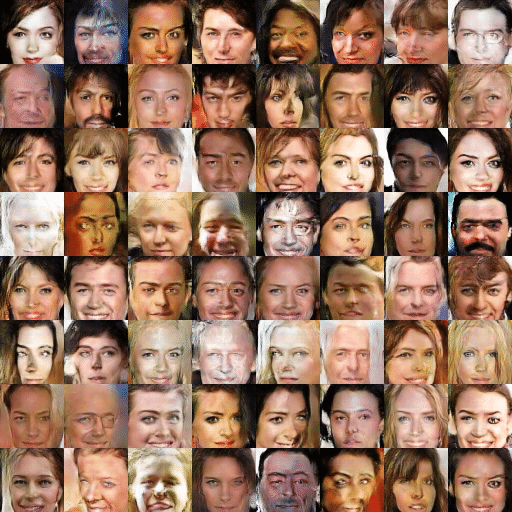

In [0]:
from IPython.display import Image
Image(filename='cele.png',height=1000,width=800)

# Prepare CelebA Faces Dataset

In [0]:
# load and plot faces
from os import listdir
from numpy import asarray
from PIL import Image
from matplotlib import pyplot

from numpy import linspace
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU,ReLU
from keras.layers import Dropout
from numpy import savez_compressed


Using TensorFlow backend.


the load_image() function is used to load a given image file and return an array of pixel data

In [0]:
# load an image as an rgb numpy array
def load_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    return pixels

once the images are loaded, we can plot them using the imshow() function from the matplotlib library.

The plot_faces() function  plots images arranged into in a square.

In [0]:
# plot a list of loaded faces
def plot_faces(faces, n):
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(faces[i])
    pyplot.show()

we are only interested in the face in each photo, and not the background, we can perform face detection and extract only the face before resizing the result to a fixed size.

In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
# confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
# print version
print(mtcnn.__version__)

0.1.0


The extract_face() function extract the face from each loaded photo and resize the extracted face pixels to a fixed size. In this case, we will use the square shape of 80×80 pixels , taking the MTCNN model and pixel values for a single photograph as arguments and returning an 80x80x3 array of pixel values.

In [0]:
# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
    # detect face in the image
    faces = model.detect_faces(pixels)
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

load_faces() function to extract the face from the loaded photo and store that in the list of faces returned.

In [0]:
# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    # prepare model
    model = MTCNN()
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # load the image
        pixels = load_image(directory + filename)
        # get face
        face = extract_face(model, pixels)
        # store
        faces.append(face)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)

loading a total of 25 images from the directory, then summarizes the size of the returned array.

Loaded:  (25, 80, 80, 3)


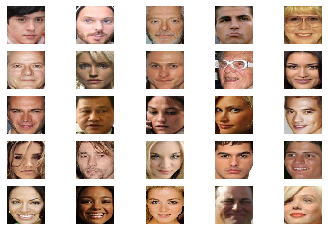

In [0]:
# directory that contains all images
directory = 'img_align_celeba/img_align_celeba/'
# load and extract all faces
faces = load_faces(directory, 25)
print('Loaded: ', faces.shape)
# plot faces
plot_faces(faces, 5)

loading and saving 32000 faces in compressed format

In [0]:
# directory that contains all images
directory = 'img_align_celeba/img_align_celeba/'
# load and extract all faces
all_faces = load_faces(directory,32000)
# save in compressed format
savez_compressed('img_align_celeba.npz', all_faces)
print("Done loading 32000 faces")

Done loading 32000 faces


In [0]:
# load the prepared dataset
from numpy import load
# load the face dataset
data = load('img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

Loaded:  (32000, 80, 80, 3)


#  Develop a Generative Adversarial Network

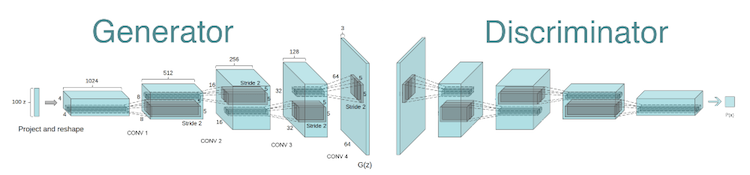

In [0]:
from IPython.display import Image
Image(filename='dc.png',height=1000,width=800)

In [0]:
#making dir to save results
!mkdir results

The define_discriminator() function takes as input one 80×80 color image an outputs a binary prediction as to whether the image is real (class=1) or fake (class=0), defining and compiling the discriminator model and returning it.

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x30
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
   
    model.add(LeakyReLU(alpha=0.2))
   
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

The define_generator() function takes as input a point in the latent space and outputs a single 80×80 color image. it defines the generator model but does not compile it as it is not trained directly, then returns the model.

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
 
    #foundation for 5x5 feature maps
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
   
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
  
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    
    model.add(LeakyReLU(alpha=0.2))
 
  
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
   
    model.add(LeakyReLU(alpha=0.2))
  
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    
    model.add(LeakyReLU(alpha=0.2))
  
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
   
    model.add(LeakyReLU(alpha=0.2))
  
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

A GAN model can be defined that combines both the generator model and the discriminator model into one model. 
This GAN model takes as input a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output is classified as real or fake.

The define_gan() function takes the already-defined generator and discriminator models as input.

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

The load_real_samples() function below implements this, returning the loaded and scaled image data ready for modeling.

In [0]:
# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load('img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

The generate_real_samples() function takes the prepared dataset as an argument, selecting and returning a random sample of face images and their corresponding class label for the discriminator, specifically class=1, indicating that they are real images.

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

The generate_latent_points() function takes the size of the latent space as an argument and the number of points required and returning them as a batch of input samples for the generator model.

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

The generate_fake_samples() function takes the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model. The function returns the generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated.

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

The summarize_performance() function generates samples and evaluates the performance of the discriminator on real and fake samples. The classification accuracy is reported which provide insight into model performance. 

The save_plot() is called to create and save a plot of the generated images, and then the model is saved to a file.

In [0]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'results/generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model file
    filename = 'results/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

plot_history function is used to plot the loss and accuracy over the num of epochs.

In [0]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results/plot_loss.png')
    pyplot.close()

The train() function takes the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments.

In [0]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=60, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d1_hist=[]
    d2_hist=[]
    a1_hist=[]
    a2_hist=[]
    g_hist=[]
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1,d_acc1 = d_model.train_on_batch(X_real, y_real)
            d1_hist.append(d_loss1)
            a1_hist.append(d_acc1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2,d_acc2= d_model.train_on_batch(X_fake, y_fake)
            d2_hist.append(d_loss1)
            a2_hist.append(d_acc2)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_hist.append(g_loss)
            # summarize loss on this batch
       
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1)%10==0:
            summarize_performance(i,g_model,d_model,dataset,latent_dim)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist) 
    print("Training Done...")

define the size of the latent space, define all three models, and train them on the loaded face dataset.

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

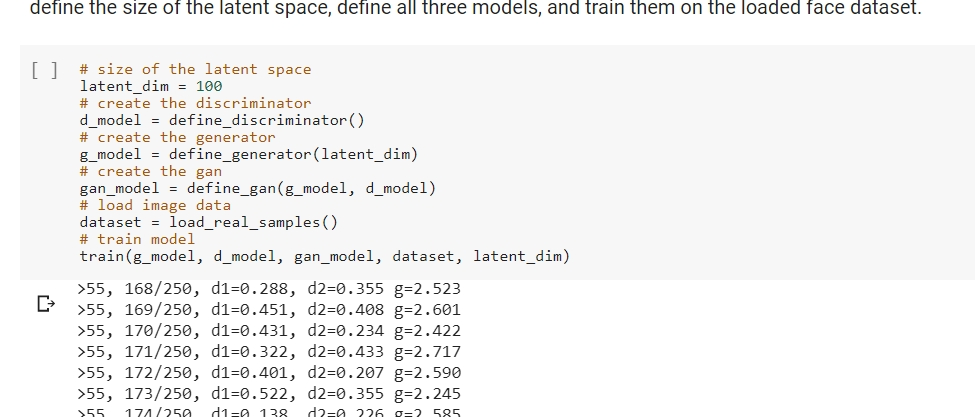

In [1]:
#showing training results as screenshot as it is omitted since it will take many pages in pdf format
from IPython.display import Image
Image(filename='img.jpg')

# Load Model and Generate Faces

The model can be loaded using the load_model() function in the Keras API. We can then generate a number of random points in the latent space and use them as input to the loaded model to generate new faces.

In [0]:
import warnings
warnings.simplefilter('ignore')

In [0]:
# create a plot of generated images
def plot(examples, n):
    # plot images
    for i in range(n * n):
    # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

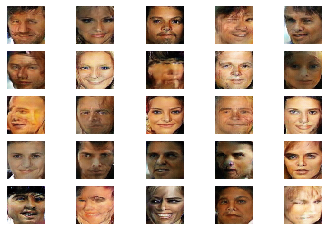

In [0]:
# load model
model = load_model('results/generator_model_060.h5')
# generate images
latent_points = generate_latent_points(100,25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot(X,5)

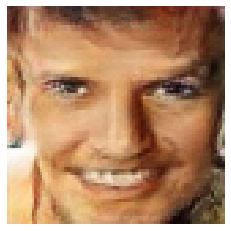

In [0]:
#generate single img from trained model
def gen_single_img(model_name):
  
  model=load_model(model_name)
  lat_pt=generate_latent_points(100,1)
  X=model.predict(lat_pt)
  x=(X+1)/2.0
  plot(x,1)
  
gen_single_img(model_name="results/generator_model_060.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


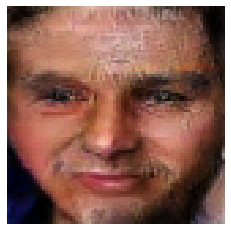

In [0]:
#generate single img from trained model
def gen_single_img(model_name):
  
  model=load_model(model_name)
  lat_pt=generate_latent_points(100,1)
  X=model.predict(lat_pt)
  x=(X+1)/2.0
  plot(x,1)
  
gen_single_img(model_name="results/generator_model_060.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


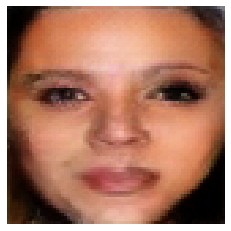

In [0]:
gen_single_img(model_name="results/generator_model_060.h5")

# Interpolation between generated images

we can create an interpolation path between two points in the latent space and generate faces along this path.

we can use is uniform interpolation between two points in the latent space byusing the linspace() NumPy function to calculate ratios of the contribution from two points, then enumerate these ratios and construct a vector for each ratio.

In [0]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

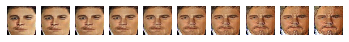

In [0]:
# load model
model = load_model('results/generator_model_060.h5')
# generate points in latent space
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot(X, len(interpolated))

In [0]:
from glob import glob
import imageio
import glob
import cv2

In [0]:
file = 'dcgan.gif'

with imageio.get_writer(file, mode='I') as writer:
  filenames = glob.glob('results/generated_plot_e*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image

[dcgan.gif](https://i.imgur.com/pQSM6kn.gifv)

# Steps used-

1-Download the CelebA dataset 

2-As the images also have background which is not useful for us so extract the face from all the images and save it.

3-Plot some of the images for visualization.

4-As the celebA dataset is very large,so select 32000 images (memory issue) and save it in compressed format for further processing.

5-Next step is to define the model architecture for generator,discriminator and combined model.

6-***Discrimator model***-It takes one input 80×80 color image an outputs a binary prediction as to whether the image is real or fake. It is designed using the LeakyReLU activation function with a slope of 0.2, using a 2×2 stride to downsample, and the adam optimizer with a learning rate of 0.0002 and a momentum of 0.5

7-***Generator model***-It takes a point as input in the latent space and outputs a single 80×80 color image. It uses FCC layer to interpret point in latent space and reshape the image in low resolution output image.This is then upsampled four times, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses LeakyReLU activation and (tanh) activation function in the output layer.
The define_generator() function defines the generator model but is not compiled as it is not trained directly.

8-***Combined model***-It is defined to combine both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately so it is marked as not trainable in this combined model to ensure that only the weights of the generator model are updated.
This combined model takes a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output is classified as real or fake.

9-Next we will define some function to generate real samples,fake samples and latent point which is used for training the model.

10-***Train the model***-First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the combined model.Class label is set to 1 for real and 0 for the fake samples and process is repeated for various epochs. 

11-Also there is various utility function defined like plot history,save plot & summarize performance to check how the model performs.

12-After training phase is over ,its time for prediction (generating new faces)

13-Load the trained model and generate the faces with the help of latent points(predict on latent pts and plot the gen. imgs).


**Reference**

https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/